In [20]:
import numpy as np
import pandas as pd

from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic, WhiteKernel
from sklearn.metrics import pairwise_distances

from datetime import datetime
import csv

from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('nba_data.csv')

In [4]:
df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,carm-elo_prob1,carm-elo_prob2,carm-elo1_post,carm-elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,score1,score2
0,1946-11-01,1947,0,NaN,TRH,NYK,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,68.0
1,1946-11-02,1947,0,NaN,CHS,NYK,1300.0,1306.7233,0.631101,0.368899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,47.0
2,1946-11-02,1947,0,NaN,PRO,BOS,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,53.0
3,1946-11-02,1947,0,NaN,STB,PIT,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,51.0
4,1946-11-02,1947,0,NaN,DTF,WSC,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,50.0


In [5]:
def plot_reg(train_x, train_y, test_x, test_y, title=None, show_train=True, timestamps=True):
    if timestamps:
        train_x = [datetime.fromtimestamp(t) for t in train_x]
        test_x = [datetime.fromtimestamp(t) for t in test_x]

    plt.figure()
    plt.title(title)
    if show_train:
        training_data, = plt.plot(train_x, train_y, '.', label='Training data')
    predictive_mean, = plt.plot(test_x, test_y, '-', label='Predictive mean')
    plt.legend(loc='upper left')
    
def fit_gpr(train_x, train_y, test_x, kernel, return_gpr=False):
    if isinstance(train_x, list):
        train_x = np.array(train_x).reshape(-1, 1)
    if isinstance(test_x, list):
        test_x = np.array(test_x).reshape(-1, 1)
    gpr = GaussianProcessRegressor(kernel=kernel, copy_X_train=False)
    gpr.fit(train_x, train_y)
    
    if len(test_x):
        test_y = gpr.predict(test_x)
    else:
        test_y = None
    
    if return_gpr:
        return test_y, gpr.kernel_, gpr
    else:
        return test_y, gpr.kernel_

### Let's check how different kernel functions will approximate our data combining mean seasonly Elo Rating for each team.

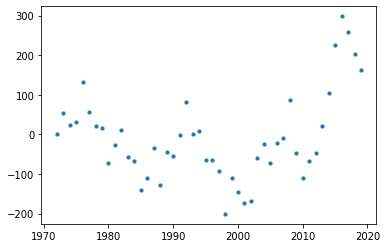

In [6]:
seasons = np.arange(1940, 2020)
team = 'GSW'
e = []
x = []
for s in seasons:
    elo_score = np.append(df[(df['season'] == s) & (df['team1'] == team)]['elo1_post'],
                          df[(df['season'] == s) & (df['team2'] == team)]['elo2_post'])
    if len(elo_score):
        x.append(s)
        e.append(np.mean(elo_score))

e = np.array(e) - 1500
plt.scatter(x, e, s=10)

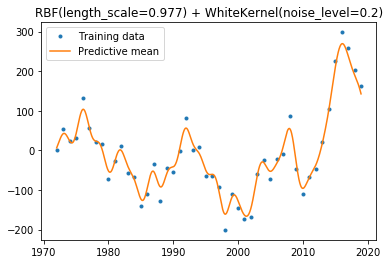

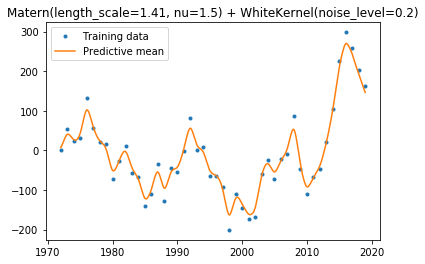

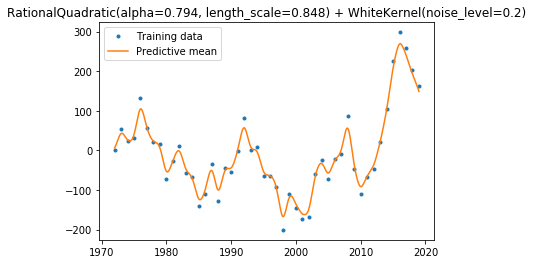

In [7]:
train_x = np.array(x).reshape(-1, 1)
train_y = e

test_x = np.linspace(np.min(train_x), np.max(train_x), 1000).reshape(-1, 1)

noise=0.2
KERNELS = np.array([RBF(), 
                   Matern(), 
                   RationalQuadratic(),
                   ])
KERNELS += WhiteKernel(noise_level=noise, noise_level_bounds=(noise, noise))


for k in KERNELS:
    test_y, kernel = fit_gpr(train_x, train_y, test_x, k)
    plot_reg(train_x, train_y, test_x, test_y, kernel, timestamps=False)

It looks as decent approximation based on data. There's not much difference in kernel's predictions so let's use RBF.

### Fitting the regression using ratings after each game has high computonial cost. Let's test how results differ when we get less ratings.

In [8]:
x = np.append(df[df['team1'] == team]['date'], df[df['team2'] == team]['date'])
e = np.append(df[df['team1'] == team]['elo1_post'], df[df['team2'] == team]['elo2_post'])
good_idx = x < '2020'
x = x[good_idx]
e = e[good_idx]
e -= 1500
x = [datetime.fromisoformat(el).timestamp() for el in x]

train_x = np.array(x).reshape(-1, 1)
train_y = e

100%|██████████| 7/7 [01:23<00:00, 11.91s/it]


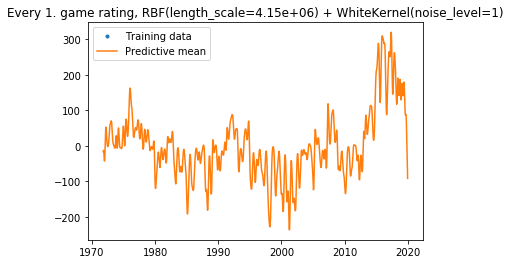

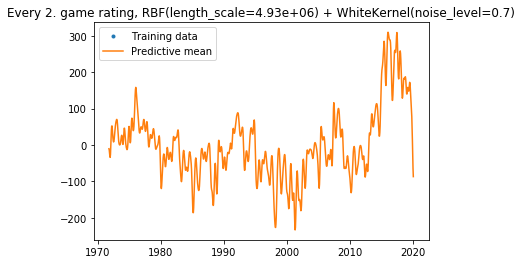

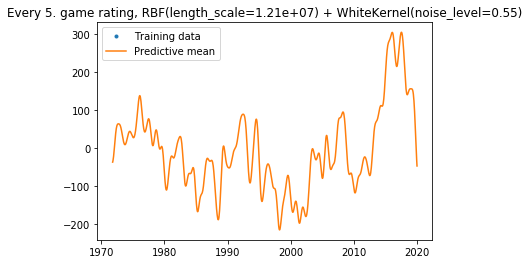

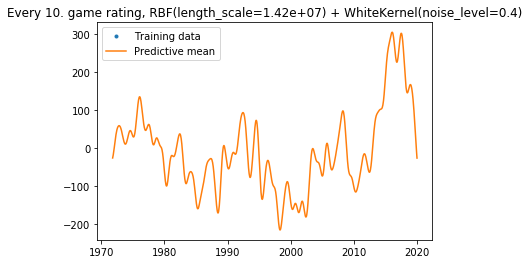

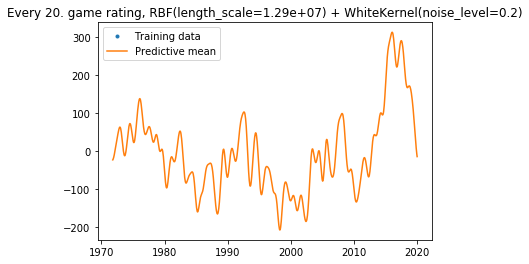

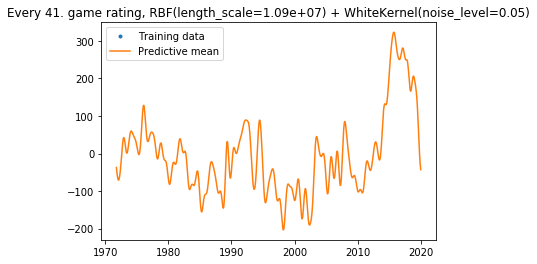

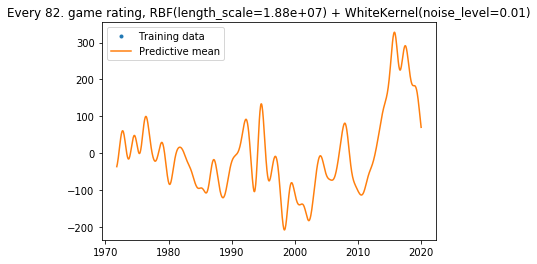

In [10]:
l_scale = 365.25 * 24 * 60 * 60
kernel = RBF(length_scale=l_scale, length_scale_bounds=(l_scale/10, l_scale*10)) 
STEPS = [1, 2, 5, 10, 20, 41, 82]
NOISES = [1, 0.7, 0.55, 0.4, 0.2, 0.05, 1e-2]

test_x = np.linspace(np.min(train_x), np.max(train_x), 1000).reshape(-1, 1)

gprs = []

for i, (s, n) in tqdm(enumerate(np.c_[STEPS, NOISES]), position=0, leave=True, total=len(STEPS)):
    s = int(s)
    w_kern = WhiteKernel(noise_level=n, noise_level_bounds=(n, n))
    
    test_y, new_kernel, gpr = fit_gpr(train_x[::s], train_y[::s], test_x, kernel + w_kern, return_gpr=True)
    gprs.append(gpr)
    
    plot_reg([], [], test_x, test_y, f'Every {s}. game rating, {new_kernel}')

We want to maximize the number of games we skip and still have a nice function including hot/cold streaks. It looks like taking every 20th Elo Rating with  satisfies our requirments.

Get ER every month

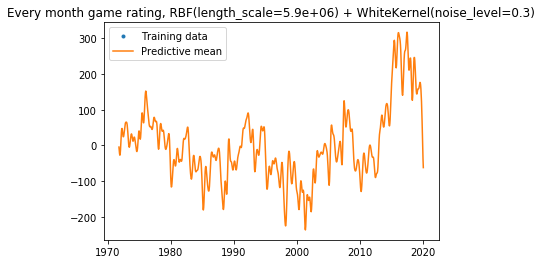

In [11]:
noise = 0.3
last_m = -1

a = np.array(list(map(lambda x: datetime.fromtimestamp(x).month, train_x)))
idxs = (a[:-1] != a[1:]).nonzero()
sb_train_x = train_x[idxs]
sb_train_y = train_y[idxs]
    
w_kern = WhiteKernel(noise_level=noise, noise_level_bounds=(noise, noise))

test_y, new_kernel = fit_gpr(sb_train_x, sb_train_y, test_x, kernel + w_kern)

plot_reg([], [], test_x, test_y, f'Every month game rating, {new_kernel}')

## Let's check how the lines of bets we're taking affect our average profit per bet

### First load all the data

In [12]:
from collections import defaultdict

In [32]:
games_df = pd.read_csv('data/nba_games_all.csv')
lines_df = pd.read_csv('data/nba_betting_money_line.csv')

games_df = games_df[games_df['is_home'] == 'f']
book = lines_df['book_name'].value_counts().index[0]
lines_df = lines_df[lines_df['book_name'] == book]

lg_df = games_df.merge(lines_df, on='game_id')

In [33]:
teams = np.unique(np.append(df['team1'], df['team2']))
gprs = defaultdict(object)
for team in tqdm(teams, position=0, leave=True):
    dates = np.append(df[df['team1'] == team]['date'], df[df['team2'] == team]['date'])
    e = np.append(df[df['team1'] == team]['elo1_post'], df[df['team2'] == team]['elo2_post'])\
    
    idx = dates < '2020'
    dates = dates[idx]
    e = e[idx]
    
    idx = np.argsort(dates)
    dates = dates[idx]
    e = e[idx]
    
    dates = np.array([datetime.fromisoformat(el).timestamp() for el in dates])
    e -= 1500

    months = np.array(list(map(lambda x: datetime.fromtimestamp(x).month, dates)))
    idx = np.nonzero(months[1:] != months[:-1])[0]
    
    train_x = dates[idx].reshape(-1, 1)
    train_y = e[idx]


    _, _, gpr = fit_gpr(train_x, train_y, [], kernel, return_gpr=True)
    
    gprs[team] = gpr

100%|██████████| 102/102 [00:03<00:00, 29.50it/s]


In [34]:
def predict_result(team1, team2, t):
    if isinstance(t, list):
        # make multiple predictions for those 2 teams
        if isinstance(t[0], str):
            for i in range(len(t)):
                t[i] = datetime.fromisoformat(t[i]).timestamp()
        
        t = np.array(t).reshape(-1, 1)
        
        skills1 = gprs[team1].predict(t)
        skills2 = gprs[team2].predict(t)
        
        res = np.full(len(t), team1)
        res[skills1 < skills2] = team2
        return res
        
    else:
        if isinstance(t, str):
            t = datetime.fromisoformat(t).timestamp()

        t = np.array(t).reshape(-1, 1)
        skill1 = gprs[team1].predict(t)
        skill2 = gprs[team2].predict(t)

        if skill1 > skill2:
            return team1
        else:
            return team2

### Done. Time to check best lines.

In [41]:
def money_boost(line):
    if line < 0:
        return 100 * (our_bet / -line)
    else:
        return line / (100 / our_bet)
    
MAX_LINES = np.arange(100, 1000, 50)
avg_per_bets = []
for max_line in tqdm(MAX_LINES, position=0, leave=True):
    money_s = defaultdict(int)
    money_d = defaultdict(int)
    our_bet = 10
    n = 0

    for i in range(len(lg_df)):
        row = lg_df.iloc[i]
        t = row['game_date']
        s = row['season']
        t1, t2 = row['matchup'].split(' vs. ')

        if t1 not in teams or t2 not in teams:
            continue

        if row['price1'] > max_line or row['price2'] > max_line:
            continue

        pred = predict_result(t1, t2, t)
        n += 1

        if pred == t2 and row['wl'] == 'W':
            money_d[t] += money_boost(row['price1'])
            money_s[s] += money_boost(row['price1'])
        elif pred == t1 and row['wl'] == 'L':
            money_d[s] += money_boost(row['price2'])
            money_s[s] += money_boost(row['price2'])
        else:
            money_d[s] -= our_bet
            money_s[s] -= our_bet

    avg_per_bet = sum(money_s.values()) / n
    avg_per_bets.append(avg_per_bet)

100%|██████████| 18/18 [01:57<00:00,  6.55s/it]


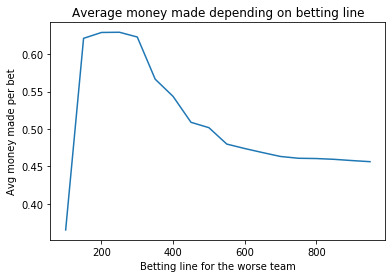

In [42]:
plt.title('Average money made depending on betting line')
plt.xlabel('Betting line for the worse team')
plt.ylabel('Avg money made per bet')
plt.plot(MAX_LINES, avg_per_bets)

Our model provide money made per bet ratio if we stick to betting on '50:50' games with line for the worse team (150, 300)

## Check how many games we get correct just by comparing Elo Ratings before game.

In [43]:
confussion_matrix = np.zeros((2, 2))
for i in trange(len(df), position=0, leave=True):
    row = df.iloc[i]
    
    if row['score1'] > row['score2']:
        if row['elo1_pre'] + 35 > row['elo2_pre']:
            confussion_matrix[0][0] += 1
        else:
            confussion_matrix[0][1] += 1
    else:
        if row['elo2_pre'] > row['elo1_pre'] + 35:
            confussion_matrix[1][1] += 1
        else:
            confussion_matrix[1][0] += 1

100%|██████████| 69635/69635 [00:13<00:00, 5073.41it/s]


In [44]:
print(f'Confussion matrix:\n{confussion_matrix}\nAccuracy: \
{np.sum(np.diag(confussion_matrix)) / np.sum(confussion_matrix)}')

Confussion matrix:
[[30428. 12365.]
 [11078. 15764.]]
Accuracy: 0.663344582465714


## We got pretty good accuracy. Let's check if we could make any money just on Elo Ratings.

In [74]:
money_s = defaultdict(int)
money_d = defaultdict(int)
our_bet = 10
n = 0
opt_max_line = 250
lg_df.rename(columns = {'game_date': 'date'}, inplace=True)
full_df = df.merge(lg_df, on=['matchup', 'date'])

for i in tqdm(range(len(full_df)), position=0, leave=True):
    row = full_df.iloc[i]
    t = row['date']
    s = row['season_y']
    t1, t2 = row['matchup'].split(' vs. ')
    
    if t1 not in teams or t2 not in teams:
        continue
        
    if row['price1'] > opt_max_line or row['price2'] > opt_max_line:
        continue
    
    if row['elo1_pre'] + 35 > row['elo2_pre']:
        pred = row['team1']
    else:
        pred = row['team2']
#     pred = predict_result(t1, t2, t)
    n += 1
    
    if pred == t2 and row['wl'] == 'W':
        money_d[t] += money_boost(row['price1'])
        money_s[s] += money_boost(row['price1'])
    elif pred == t1 and row['wl'] == 'L':
        money_d[s] += money_boost(row['price2'])
        money_s[s] += money_boost(row['price2'])
    else:
        money_d[s] -= our_bet
        money_s[s] -= our_bet

100%|██████████| 12062/12062 [00:04<00:00, 2841.15it/s]


In [75]:
print(f'Total money made: {sum(money_d.values())}, first bet placed: {min(money_d.keys())}, last: {max(money_d.keys())}')
print(f'Average money made from one bet: {sum(money_s.values()) / n}, bets taken: {n}, bets skipped: {len(lg_df) - n}')
print(f'Average money made in one day: {sum(money_d.values()) / len(money_d.values())}')
print(f'Average money made in a season: {sum(money_s.values()) / len(money_s.values())}')

Total money made: -1684.7128540000647, first bet placed: 2006-07, last: 2018-05-06
Average money made from one bet: -0.22450864259062794, bets taken: 7504, bets skipped: 7390
Average money made in one day: -1.2610126152695096
Average money made in a season: -140.39273783333934


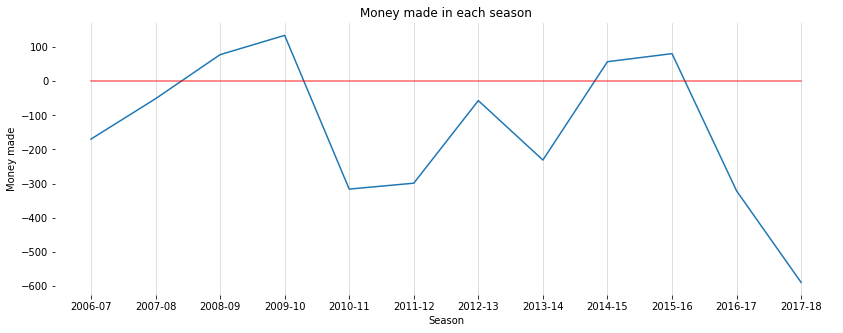

In [77]:
x, y = [], []
for k, v in money_s.items():
    x.append(k)
    y.append(v)
    
x = np.array(x)
y = np.array(y)
idx = np.argsort(x)
x = x[idx]
y = y[idx]

fig, ax = plt.subplots(figsize=(14, 5))
ax.set_title('Money made in each season')
ax.set_xlabel('Season')
ax.set_ylabel('Money made')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax.grid(axis='x', alpha=0.5)

ax.plot(x, y)
ax.plot(x, np.zeros(x.shape), color='r', alpha=0.6)
None